### Step 1. Import the required libraries

In [2]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

### Step 2. Basic Implementation

In [8]:
def bspline(
    x: np.ndarray,
    id: int,
    degree: int,
    knots: np.ndarray,
) -> torch.Tensor:
    """
    Compute B-spline basis functions.

    Args:
        x (torch.Tensor): Input tensor of shape (N, D).
        id (int): Index of the B-spline basis function.
        knots (torch.Tensor): Knot vector of shape (K,).
        degree (int): Degree of the B-spline.

    Returns:
        torch.Tensor: B-spline basis functions of shape (N, K - degree - 1).
    """
    
    if degree == 0:
        # Degree 0 B-spline is 1 if x is in the knot span, else 0
        return (x >= knots[id]) & (x < knots[id + 1])
    
    return (x - knots[id]) * bspline(x, id, degree-1, knots) / (knots[id+degree] - knots[id]) + (knots[id+degree+1] - x) * bspline(x, id+1, degree-1, knots) / (knots[id+degree+1] - knots[id+1])
    

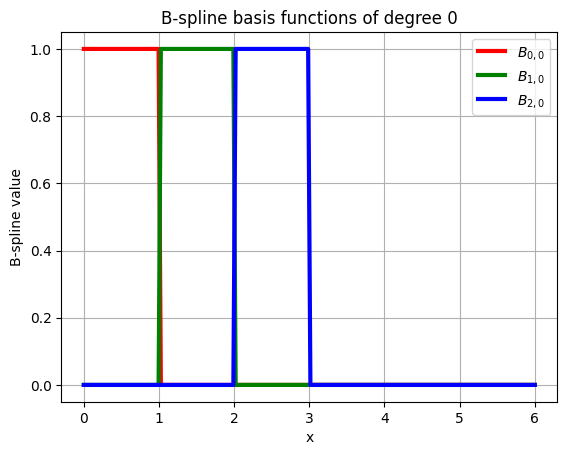

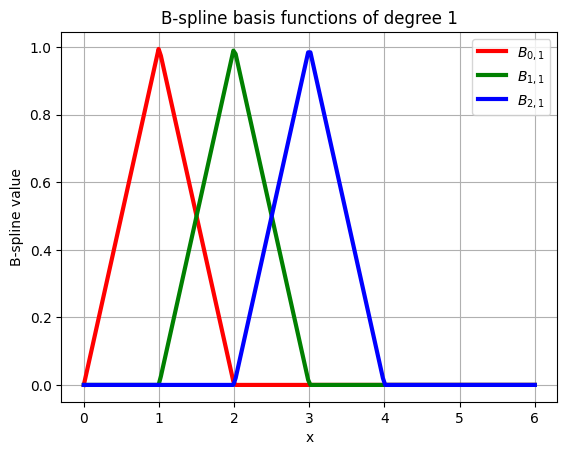

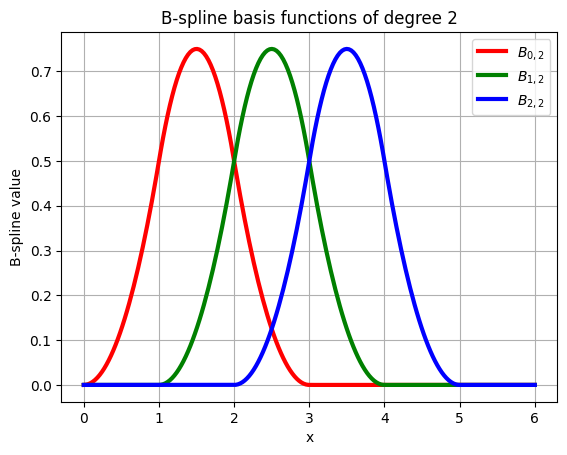

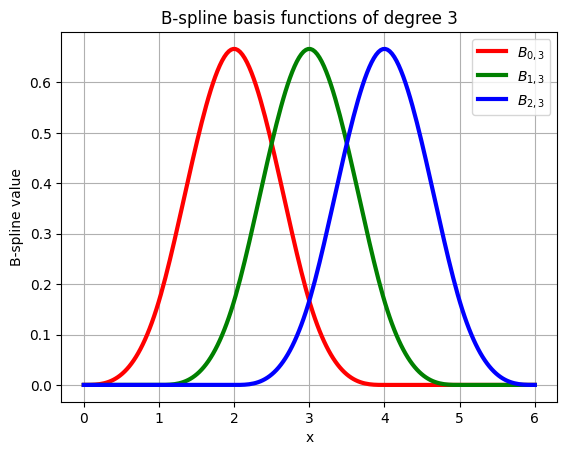

In [41]:
knots = np.array([0, 1, 2, 3, 4, 5, 6])
splines_number = 3

for degree in [0, 1, 2, 3]:
    x = np.linspace(0, 6, 200)
    y1 = bspline(x, 0, degree=degree, knots=knots)
    y2 = bspline(x, 1, degree=degree, knots=knots)
    y3 = bspline(x, 2, degree=degree, knots=knots)

    plt.plot(x, y1, color='red', linewidth=3)
    plt.plot(x, y2, color='green', linewidth=3)
    plt.plot(x, y3, color='blue', linewidth=3)
    # Add legend
    plt.legend([f"$B_{{0,{degree}}}$", f"$B_{{1,{degree}}}$", f"$B_{{2,{degree}}}$"])
    
    plt.title(f"B-spline basis functions of degree {degree}")
    plt.xlabel("x")
    plt.ylabel("B-spline value")
    plt.grid()
    plt.savefig(f"bspline_degree_{degree}.pdf", dpi=600)
    plt.show()

Take a random set of coefficients and debug $\sum_i c_iB_{i,3}(x)$

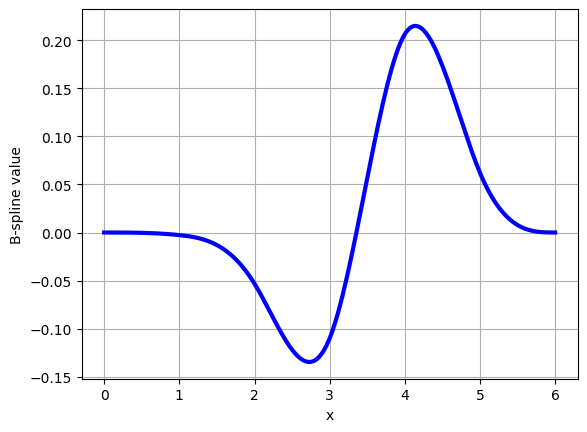

In [43]:
coeffs = np.random.normal(size=splines_number)
y = coeffs[0] * y1 + coeffs[1] * y2 + coeffs[2] * y3
plt.plot(x, y, color='blue', linewidth=3)
plt.xlabel("x")
plt.ylabel("B-spline value")
plt.grid()
plt.show()

### Step 3. Grid Extension

In [44]:
def extend_grid(grid, k):
    """
    Extends the grid on either size by k steps

    Args:
        grid: number of splines x number of control points
        k: spline order

    Returns:
        new_grid: number of splines x (number of control points + 2 * k)
    """
    n_intervals = len(grid) - 1
    bucket_size = (grid[-1] - grid[0]) / n_intervals
    
    for i in range(k):
        grid = torch.cat([grid[:1] - bucket_size, grid])
        grid = torch.cat([grid, grid[-1:] + bucket_size])

    return grid

In [58]:
def eval_basis_functions(x_eval, grid, d):
    """
    Returns the value of basis functions defiend for order-d splines and control points defined in `grid`. 

    Args:
        x_eval: [number of samples, number of dimensions]
        grid: [number of splines, number of control points]
        d (scalar): order of spline

    Returns:
        bases: number of samples x number of dimensions x number of basis functions
    """
    
    grid = extend_grid(grid, d)
    
    for idx in range(d+1):
        if idx == 0:
            bases = (x >= grid[:-1]) * (x < grid[1:]) * 1.0 # step function; for each x in between the corresponding knots, the value is 1.
        else:
            bases1 = (x - grid[:-(idx+1)]) / (grid[1:-idx] - grid[:-(idx+1)]) * bases[:-1]
            bases2 = (grid[(idx+1):] - x) / (grid[(idx+1):] - grid[1:-idx]) * bases[1:]
            bases = bases1 + bases2

    return bases.transpose(1, 2) * 1.0

In [59]:
grid = torch.linspace(-1, 1, steps=10)
x = torch.linspace(-1, 1, steps=1000)

value1 = eval_basis_functions(x, grid, d=0)
value1

RuntimeError: The size of tensor a (1000) must match the size of tensor b (9) at non-singleton dimension 0